In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'intel-image-classification' dataset.
Path to dataset files: /kaggle/input/intel-image-classification


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


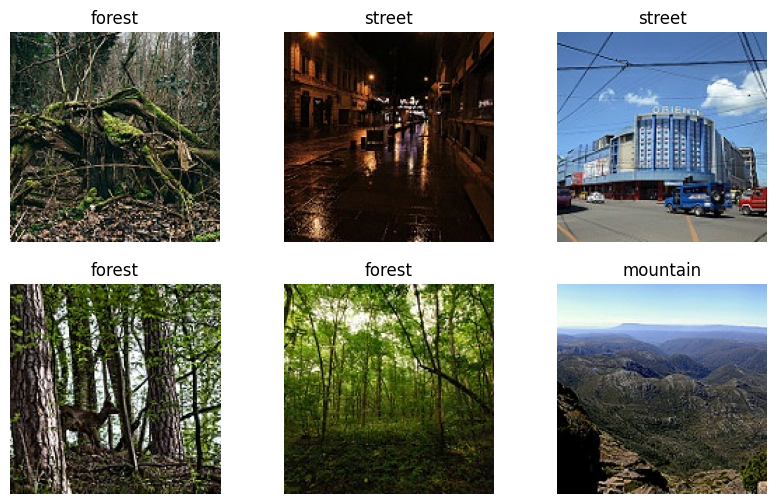

Preprocessing complete: Resize, Normalize, Split, Augmentation applied.


In [16]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Path from kagglehub
dataset_path = path
train_dir = os.path.join(dataset_path, 'seg_train', 'seg_train')
test_dir  = os.path.join(dataset_path, 'seg_test', 'seg_test')

# Image size and batch size
img_size = (150, 150)
batch_size = 32

# Load training and validation data (80% train, 20% validation)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=42
)

# Load test data
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)

# Show one image from each class
plt.figure(figsize=(10,6))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Normalize pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Data augmentation (only for training)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

print("Preprocessing complete: Resize, Normalize, Split, Augmentation applied.")

In [17]:


# Image shape
img_height, img_width = 150, 150
num_classes = len(class_names)

# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train model (only 3 epochs)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[early_stop]
)

print("Training completed.")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 611s 2s/step - accuracy: 0.4149 - loss: 1.4641 - val_accuracy: 0.5969 - val_loss: 0.9967
Epoch 2/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.5629 - loss: 1.1020 - val_accuracy: 0.6358 - val_loss: 0.9631
Epoch 3/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - accuracy: 0.6148 - loss: 1.0094 - val_accuracy: 0.7028 - val_loss: 0.8044
Training completed.


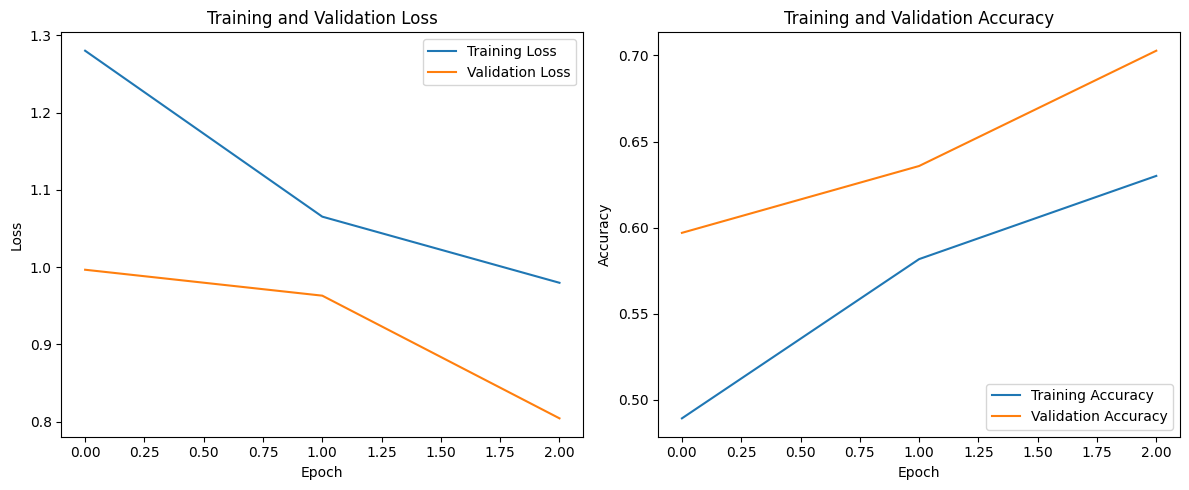

In [18]:
import matplotlib.pyplot as plt

# Get the history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [20]:
oss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {oss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 419ms/step - accuracy: 0.7027 - loss: 0.8159
Test Loss: 0.8165
Test Accuracy: 0.7053



Classification Report:
              precision    recall  f1-score   support

   buildings       0.55      0.73      0.63       437
      forest       0.88      0.93      0.90       474
     glacier       0.74      0.61      0.67       553
    mountain       0.67      0.62      0.65       525
         sea       0.66      0.55      0.60       510
      street       0.75      0.82      0.78       501

    accuracy                           0.71      3000
   macro avg       0.71      0.71      0.70      3000
weighted avg       0.71      0.71      0.70      3000



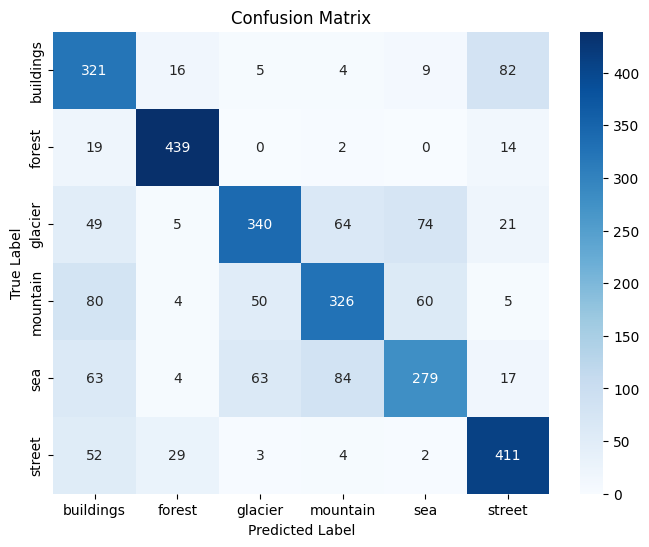

In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predictions from the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Report Accuracy, Precision, Recall, F1-score per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


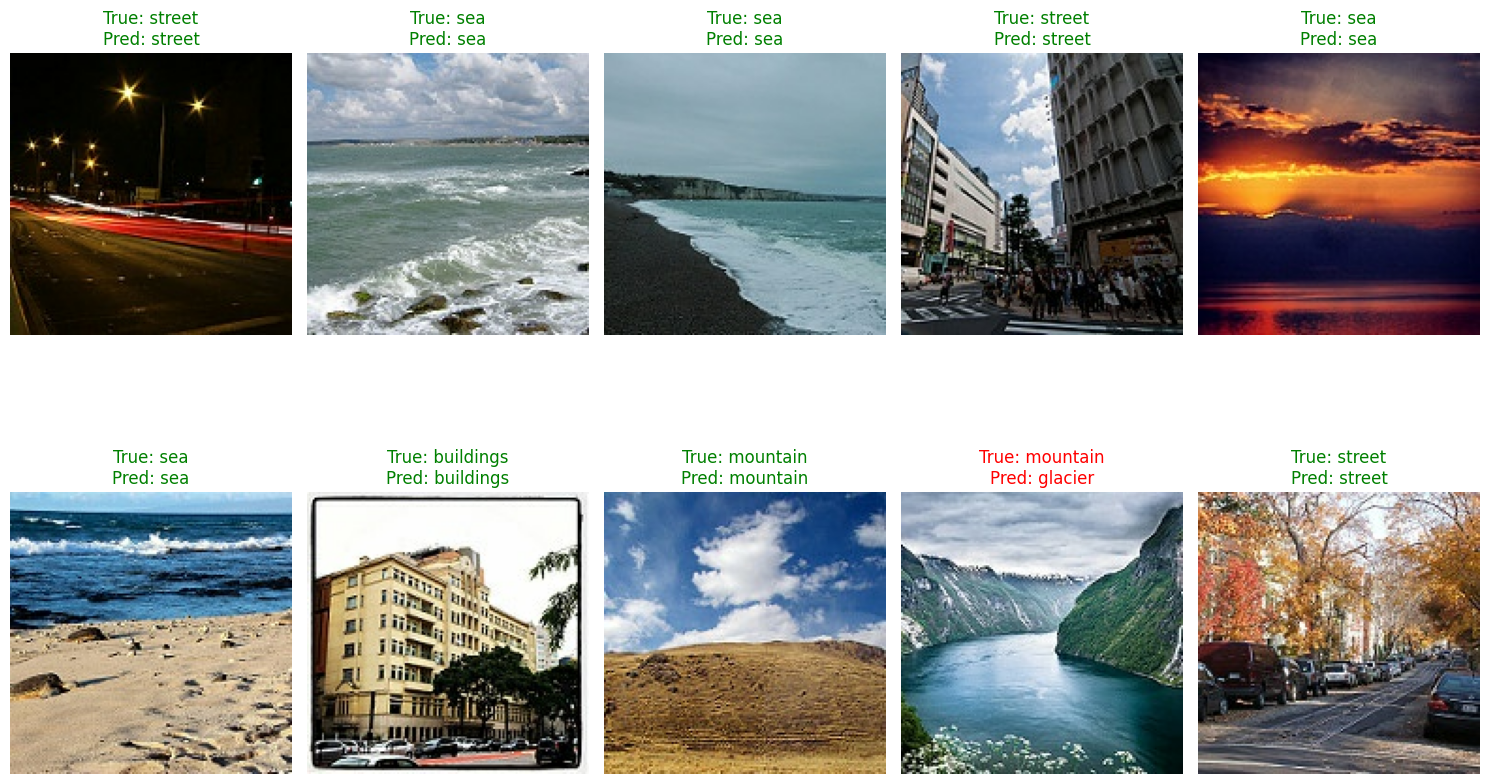

In [22]:
plt.figure(figsize=(15, 10))

# Take a batch of images and labels from the test dataset
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Display up to 10 images
    num_images_to_show = min(10, len(images))
    for i in range(num_images_to_show):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy())
        true_label = class_names[labels[i]]
        predicted_label = class_names[predicted_classes[i]]

        color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis("off")

plt.tight_layout()
plt.show()